In [1]:
import os
import time
from joblib import dump, load

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

data_path = "..\\data\\stackoverflow\\"
model_path = data_path + "models\\"
tb_path = os.path.join(model_path, "tb_logs")

np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = "{:,.2f}".format

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("Tensorflow version: ", tf.__version__)
print("Tensorflow GPU detection: ", tf.config.list_physical_devices('GPU'))

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Tensorflow version:  2.6.0-dev20210413
Tensorflow GPU detection:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def tb_logdir(name=None):
    if name:
        return os.path.join(tb_path, name)        
    else:
        current_time = time.strftime("mlp_%Y%m%d-%H%M%S")
        return os.path.join(tb_path, current_time)

In [3]:
mlb = MultiLabelBinarizer()
df_tags = pd.read_pickle(data_path + 'Top_Tags.pkl')
df_tags_test = pd.read_pickle(data_path + 'Top_Tags_test.pkl')
df_tags_full = pd.concat([df_tags,df_tags_test])
mlb.fit_transform(df_tags_full['Tags_T50'])

y_tags = mlb.transform(df_tags['Tags_T50'])
y_tags_test = mlb.transform(df_tags_test['Tags_T50'])

In [4]:
# y_dict = load(data_path + 'y_dict_top50.joblib')
title_vectorizer = load(model_path + 'lemma_title_vectorizer.joblib')
body_vectorizer = load(model_path + 'lemma_body_vectorizer_12.joblib')

In [5]:
df_lemma = pd.read_pickle(data_path + 'nltk_lemma_stop.pkl')
df_lemma_test = pd.read_pickle(data_path + 'nltk_lemma_stop_test.pkl')
df_lemma['Title'] = df_lemma['Title'].apply(lambda row: ' '.join(row))
df_lemma['Body'] = df_lemma['Body'].apply(lambda row: ' '.join(row))
df_lemma_test['Title'] = df_lemma_test['Title'].apply(lambda row: ' '.join(row))
df_lemma_test['Body'] = df_lemma_test['Body'].apply(lambda row: ' '.join(row))

In [6]:
X_title = title_vectorizer.transform(df_lemma['Title'])
X_title_test = title_vectorizer.transform(df_lemma_test['Title'])
X_body = body_vectorizer.transform(df_lemma['Body'])
X_body_test = body_vectorizer.transform(df_lemma_test['Body'])

In [7]:
metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.4,name='patr'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
#     keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
LABEL_SMOOTHING = 0
optimizer = keras.optimizers.Adam(learning_rate=0.003)
loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)

In [31]:
COUNT = 100000
SPLIT_RATIO = .8
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 64

ds_body =  tf.data.Dataset.from_tensor_slices((X_body[:COUNT].toarray(), y_tags[:COUNT]))
ds_body_train, ds_body_valid = ds_body.take(ds_body.cardinality().numpy()*SPLIT_RATIO), ds_body.skip(ds_body.cardinality().numpy()*SPLIT_RATIO)
body_train_data = ds_body_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
body_valid_data = ds_body_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [32]:
DIM = 48
DROPOUT = .4

model = keras.Sequential([
    
    layers.Dense(DIM, input_shape=(4000,), activation='relu',
#                  kernel_initializer="he_normal",
#                  kernel_regularizer=keras.regularizers.l1(0.000003)
                ),
#     layers.BatchNormalization(),
    layers.Dropout(DROPOUT),

    layers.Dense(DIM, activation='relu', 
#                  kernel_initializer="he_normal",
#                  kernel_regularizer=keras.regularizers.l1(0.000003)
                ),
    layers.Dropout(DROPOUT),
    layers.Dense(51, activation='sigmoid'),
])

    
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 48)                192048    
_________________________________________________________________
dropout_10 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 48)                2352      
_________________________________________________________________
dropout_11 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 51)                2499      
Total params: 196,899
Trainable params: 196,899
Non-trainable params: 0
_________________________________________________________________


In [33]:
logdir = tb_logdir('tfidf_body_mlp')

tb_callback = tf.keras.callbacks.TensorBoard(
        logdir,
        update_freq='batch',
        )
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=4,
    )
history = model.fit(
    body_train_data,
    epochs=20,
    validation_data=body_valid_data,
    validation_steps=3,
    callbacks=[tb_callback, es_callback],
)

Epoch 1/20
4821/4821 [==============================] - 60s 12ms/step - loss: 0.1113 - patr: 0.2140 - recall: 0.0681 - auc: 0.8256 - fp: 3611.9581 - fn: 52491.9994 - tp: 4903.0662 - accuracy: 0.9705 - precision: 0.4798 - val_loss: 0.0736 - val_patr: 0.6087 - val_recall: 0.1471 - val_auc: 0.9469 - val_fp: 8.0000 - val_fn: 58.0000 - val_tp: 10.0000 - val_accuracy: 0.9730 - val_precision: 0.5556call: 0.0609 - auc: 0.8173 - fp:  - ETA: 3s - loss: 0.1123 - patr: 0.2074 - recall: 0.0650 - auc: 0.8221 - fp: 3332.0022 - fn: 49119.6226 - tp: 4369.2208 - accuracy: 0 - ETA: 2s - loss: 0.1119 - patr: 0.2098 - recall: 0.0662 - auc: 0.8235 - fp: 3435.7096 - fn: 50377.3237 - tp: 4565.9
Epoch 2/20
4821/4821 [==============================] - 63s 13ms/step - loss: 0.0825 - patr: 0.4763 - recall: 0.1927 - auc: 0.9176 - fp: 4987.4753 - fn: 45939.0944 - tp: 11387.8511 - accuracy: 0.9740 - precision: 0.6891 - val_loss: 0.0681 - val_patr: 0.6829 - val_recall: 0.2794 - val_auc: 0.9561 - val_fp: 7.0000 - val_

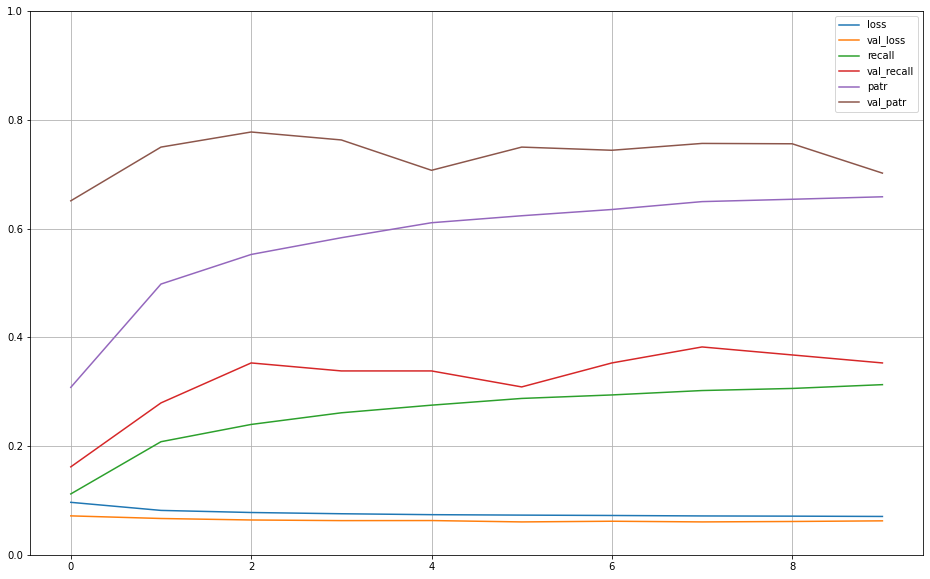

In [30]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'patr', 'val_patr' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [19]:
model.evaluate(X_body_test.toarray(),y_tags_test)

433/433 [==============================] - 4s 8ms/step - loss: 0.0678 - patr: 0.7142 - recall: 0.3486 - auc: 0.9458 - fp: 2207.0000 - fn: 13562.0000 - tp: 7258.0000 - accuracy: 0.9777 - precision: 0.7668


[0.06777720153331757,
 0.7142491340637207,
 0.3486071228981018,
 0.9458403587341309,
 2207.0,
 13562.0,
 7258.0,
 0.9776527881622314,
 0.7668251395225525]

In [16]:
COUNT = 100000
SPLIT_RATIO = .8
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 128
ds_title =  tf.data.Dataset.from_tensor_slices((X_title[:COUNT].toarray(), y_tags[:COUNT]))
ds_title_train, ds_title_valid = ds_title.take(ds_title.cardinality().numpy()*SPLIT_RATIO), ds_title.skip(ds_title.cardinality().numpy()*SPLIT_RATIO)
title_train_data = ds_title_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
title_valid_data = ds_title_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [17]:
metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.4,name='patr'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
#     keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
LABEL_SMOOTHING = 0
optimizer = keras.optimizers.Adam(learning_rate=0.003)
loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)

In [29]:
DIM = 24
DROPOUT = .25

model = keras.Sequential([
    
    layers.Dense(DIM, input_shape=(1000,), activation='relu',
#                  kernel_initializer="he_normal",
#                  kernel_regularizer=keras.regularizers.l1(0.000003)
                ),
#     layers.BatchNormalization(),
    layers.Dropout(DROPOUT),

    layers.Dense(DIM, activation='relu', 
#                  kernel_initializer="he_normal",
#                  kernel_regularizer=keras.regularizers.l1(0.000003)
                ),
    layers.Dropout(DROPOUT),
    layers.Dense(51, activation='sigmoid'),
])

    
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 24)                24024     
_________________________________________________________________
dropout_12 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 24)                600       
_________________________________________________________________
dropout_13 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 51)                1275      
Total params: 25,899
Trainable params: 25,899
Non-trainable params: 0
_________________________________________________________________


In [30]:
tb_callback = keras.callbacks.TensorBoard(tb_logdir())
history = model.fit(
    title_train_data,
    epochs=7,
    validation_data=title_valid_data,
    validation_steps=3,
#     callbacks=[tb_callback],
)

Epoch 1/7
1206/1206 [==============================] - 25s 20ms/step - loss: 0.1362 - patr: 0.1364 - recall: 0.0612 - auc: 0.7736 - fp: 5411.5485 - fn: 53400.7399 - tp: 4304.1947 - accuracy: 0.9669 - precision: 0.3406 - val_loss: 0.0737 - val_patr: 0.5936 - val_recall: 0.1778 - val_auc: 0.9382 - val_fp: 7.0000 - val_fn: 222.0000 - val_tp: 48.0000 - val_accuracy: 0.9766 - val_precision: 0.8727
Epoch 2/7
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0846 - patr: 0.4742 - recall: 0.2048 - auc: 0.9062 - fp: 4213.5476 - fn: 45452.7440 - tp: 11981.9056 - accuracy: 0.9748 - precision: 0.7360 - val_loss: 0.0671 - val_patr: 0.7397 - val_recall: 0.2926 - val_auc: 0.9460 - val_fp: 14.0000 - val_fn: 191.0000 - val_tp: 79.0000 - val_accuracy: 0.9791 - val_precision: 0.8495
Epoch 3/7
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0804 - patr: 0.5479 - recall: 0.2393 - auc: 0.9171 - fp: 4383.9677 - fn: 43577.9238 - tp: 13856.8832 - accuracy: 0.9757 - preci

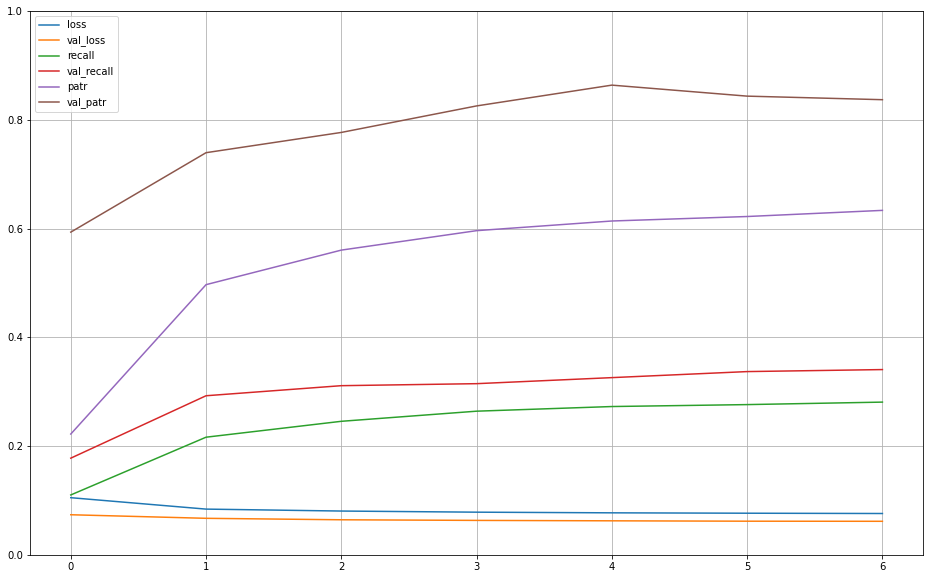

In [31]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'patr', 'val_patr' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [39]:
LABEL_SMOOTHING = 0
optimizer = keras.optimizers.Adam(learning_rate=0.003)
loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)

In [45]:
COUNT=100000
SPLIT_RATIO = .8
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 128
ds_concat =  tf.data.Dataset.from_tensor_slices(((X_title[:COUNT].toarray(), X_body[:COUNT].toarray()), y_tags[:COUNT]))
ds_concat_train, ds_concat_valid = ds_concat.take(ds_concat.cardinality().numpy()*SPLIT_RATIO), ds_concat.skip(ds_concat.cardinality().numpy()*SPLIT_RATIO)
concat_train_data = ds_concat_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
concat_valid_data = ds_concat_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [52]:
DIM_TITLE = 24
# DROPOUT_TITLE = .25
DROPOUT_TITLE = .20
DIM_BODY = 48
# DROPOUT_BODY = .4
DROPOUT_BODY = .35
DROPOUT_CONCAT = .25

input_title = tf.keras.layers.Input(shape=(1000,), name="title_input")
hidden_title_1 = tf.keras.layers.Dense(DIM_TITLE, activation='relu')(input_title)
dropout_title_1 = tf.keras.layers.Dropout(DROPOUT_TITLE)(hidden_title_1)
# hidden_title_2 = tf.keras.layers.Dense(DIM_TITLE, activation='relu')(dropout_title_1)
# dropout_title_2 = tf.keras.layers.Dropout(DROPOUT)(hidden_title_2)

input_body = tf.keras.layers.Input(shape=(4000,), name="body_input")
hidden_body_1 = tf.keras.layers.Dense(DIM_BODY, activation='relu')(input_body)
dropout_body_1 = tf.keras.layers.Dropout(DROPOUT_BODY)(hidden_body_1)
# hidden_body_2 = tf.keras.layers.Dense(DIM_BODY, activation='relu')(dropout_body_1)
# dropout_body_2 = tf.keras.layers.Dropout(DROPOUT)(hidden_body_2)

# concat = tf.keras.layers.concatenate([dropout_title_2, dropout_body_2])
concat = tf.keras.layers.concatenate([dropout_title_1, dropout_body_1])
hidden_concat = tf.keras.layers.Dense(48, activation='relu')(concat)
dropout_concat = tf.keras.layers.Dropout(DROPOUT_CONCAT)(hidden_concat)

# output = tf.keras.layers.Dense(51, activation='sigmoid')(concat)
output = tf.keras.layers.Dense(51, activation='sigmoid')(dropout_concat)

model = tf.keras.Model(inputs=[input_title, input_body], outputs=[output])

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        [(None, 1000)]       0                                            
__________________________________________________________________________________________________
body_input (InputLayer)         [(None, 4000)]       0                                            
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 24)           24024       title_input[0][0]                
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 48)           192048      body_input[0][0]                 
___________________________________________________________________________________________

In [50]:
tb_callback = keras.callbacks.TensorBoard(tb_logdir())
history = model.fit(
    concat_train_data,
    epochs=7,
    validation_data=concat_valid_data,
#     validation_steps=3,
#     callbacks=[tb_callback],
)

Epoch 1/7
4821/4821 [==============================] - 132s 27ms/step - loss: 0.0987 - patr: 0.6088 - recall: 0.3144 - auc: 0.9275 - fp: 8472.1794 - fn: 59812.9067 - tp: 26290.9662 - accuracy: 0.9771 - precision: 0.7583 - val_loss: 0.0575 - val_patr: 0.8249 - val_recall: 0.4179 - val_auc: 0.9648 - val_fp: 2756.0000 - val_fn: 16750.0000 - val_tp: 12027.0000 - val_accuracy: 0.9802 - val_precision: 0.813631s - loss: 0.1058 - patr: 0.6078 - recall: 0.3190 - auc: 0.9265 - fp: 6745.2462 - fn: 47862.4042 - tp: 21156.3960 - accuracy: 0.9773 - prec - ETA: 30s - loss: 0.1056 - patr: 0.6077 - recall: 0.3187 - auc: 0.9265 - fp: 6788.0387 - fn: 48180.4366  - E - ETA: 16s - loss: 0.1021 - patr: 0.6072 - recall: 0.3160 - auc: 0.926
Epoch 2/7
4821/4821 [==============================] - 119s 25ms/step - loss: 0.0627 - patr: 0.7684 - recall: 0.4027 - auc: 0.9535 - fp: 6957.4535 - fn: 33876.8745 - tp: 23449.5691 - accuracy: 0.9791 - precision: 0.7680 - val_loss: 0.0539 - val_patr: 0.8672 - val_recall: 0

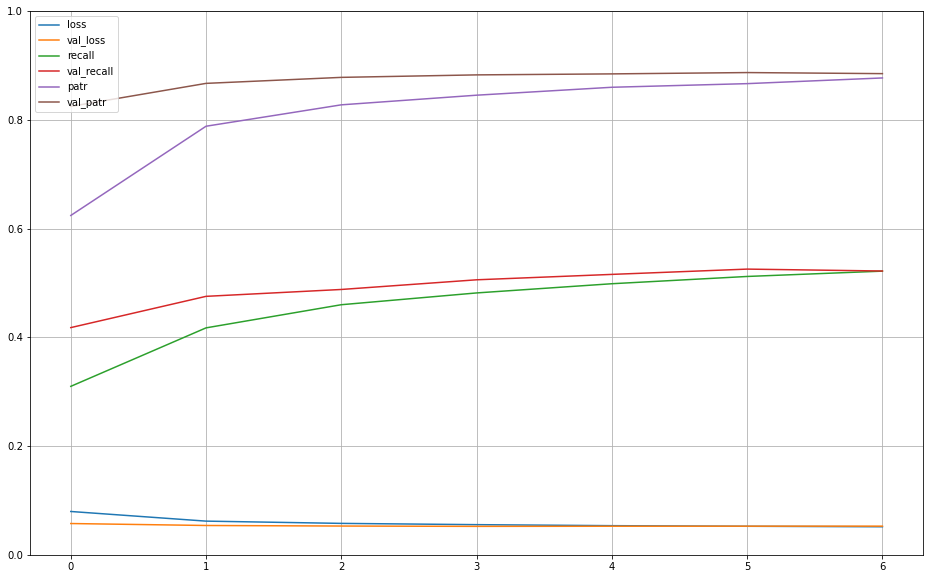

In [51]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'patr', 'val_patr' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

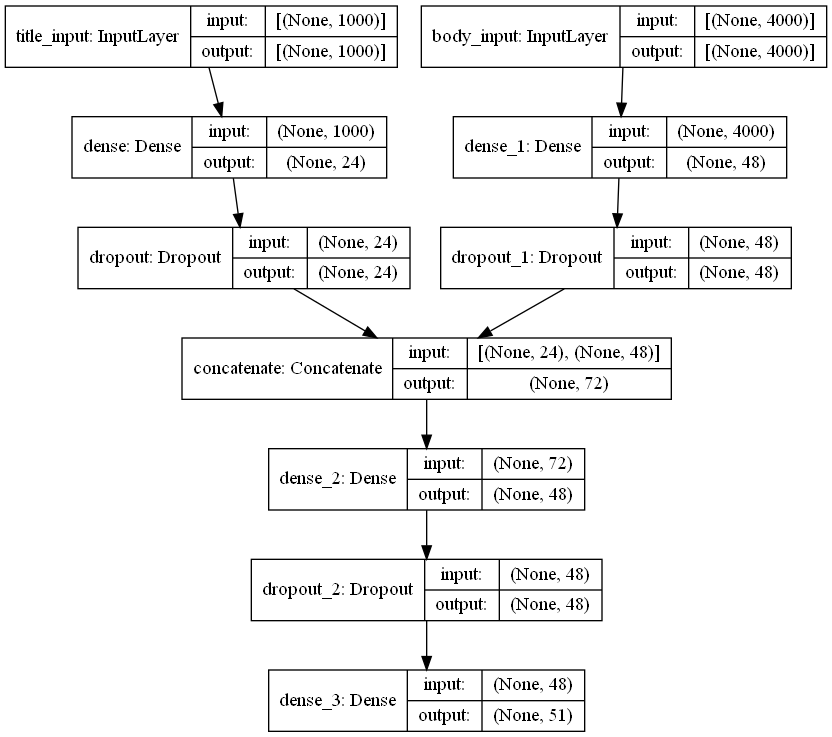

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)
plt.savefig(ddatapath + "pict_MODEL_TFIDF.png")

In [30]:
model.evaluate((X_title_test.toarray(), X_body_test.toarray()) , y_tags_test)

433/433 [==============================] - 4s 8ms/step - loss: 0.0550 - precision_at_recall: 0.8763 - recall: 0.4823 - auc: 0.9630 - fp: 2265.0000 - fn: 10778.0000 - tp: 10042.0000 - accuracy: 0.9815 - precision: 0.8160


[0.055020418018102646,
 0.876301646232605,
 0.4823246896266937,
 0.9630089998245239,
 2265.0,
 10778.0,
 10042.0,
 0.9815160632133484,
 0.8159583806991577]

In [39]:
ds_test =  tf.data.Dataset.from_tensor_slices(((X_title_test.toarray(), X_body_test.toarray()), )).batch(10)

In [40]:
res = model.predict(ds_test , y_tags_test)

In [52]:
mlb.inverse_transform(y_tags_test[2000:2010])

[('php', 'woocommerce', 'wordpress'),
 ('arrays', 'reactjs'),
 ('android', 'firebase', 'java'),
 ('other',),
 ('c',),
 ('mysql',),
 ('mysql', 'sql'),
 ('numpy', 'pandas', 'python'),
 ('javascript', 'typescript'),
 ('firebase', 'javascript')]

In [54]:
threshold = .2
tmp= pd.DataFrame(res[2000:2010]).applymap(lambda x:1 if x>threshold else 0)
mlb.inverse_transform(tmp.values)

[('php', 'woocommerce', 'wordpress'),
 ('javascript',),
 ('firebase',),
 ('other', 'python'),
 ('c', 'c++'),
 ('c#', 'mysql', 'other', 'sql'),
 ('sql',),
 ('dataframe', 'numpy', 'pandas', 'python'),
 ('other',),
 ('firebase', 'javascript')]

In [49]:
mlb.inverse_transform(y_test[8750:8760])

[('javascript', 'python'),
 ('java',),
 ('other',),
 ('c++',),
 ('java',),
 ('python',),
 ('other',),
 ('bash',),
 ('dataframe', 'list', 'pandas', 'python'),
 ('css', 'html')]

NameError: name 'mlb' is not defined

In [51]:
res = model.predict(X_test[8750:8760])
for z in np.arange(res.shape[0]):
    classes = ""
    for r in np.arange(len(mlb.classes_)):
        if res[z][r]>.15:
            classes = classes + mlb.classes_[r] + ", "
    print("classe: ", classes )

classe:  other, python, 
classe:  arrays, javascript, python, 
classe:  python, 
classe:  c++, rust, 
classe:  java, 
classe:  python, 
classe:  javascript, sql, 
classe:  bash, other, python, 
classe:  dataframe, pandas, python, 
classe:  javascript, reactjs, 


In [54]:
df_tags_test[8750:8760]

,Tags_T100,Tags_T50,Tags_T10
8750,"[javascript, python]","[javascript, python]","[javascript, python]"
8751,[java],[java],[java]
8752,[other],[other],[other]
8753,[c++],[c++],[c++]
8754,"[java, database]",[java],[java]
8755,[python],[python],[python]
8756,[vba],[other],[other]
8757,"[bash, loops]",[bash],[other]
8758,"[python, pandas, list, dataframe]","[python, pandas, list, dataframe]","[python, pandas, dataframe]"
8759,"[html, css]","[html, css]",[other]


In [52]:
df_lemma_test.loc[8759,'Title']

'get hang indent dd tag cs also content'

In [53]:
df_lemma_test.loc[8759,'Body']

'page bunch definition list guy make style mockups word come brilliant idea render definition list term value hang indent admit actually brilliant difficult play around quite bit hang indent really necessary page becomes ugly grid suboptimal anyway page render break content appear hang indent style honor actually oppose method say hang indent hang keyword glitchy like render believe else'